### Susannah D'Arcy
# Algorithmic Bias

Algorithmic Bias is when a system will make systematic and repeatable errors which creates unfair outcomes. One type of algorithmic bias is majority bias, which is when the algorithm will have a bias towards the majority data element simply because it was a majority in the training set. Due to this the algorithm/system will have a low chance for predicting a minority class. These types of datasets are very popular in medicine, especially for classification of diseases as a majority of people won't have that disease. Which means there will be less data points classified for disease, thus creating a unbalanced dataset.

First I will import the Haberman's Survival Data Set from the UCI ML repository. And assigned survived (class 2) with the label L5, and the others with GE5.

In [58]:
import numpy as np
import pandas as pd
from collections import Counter

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


Let's now separate our into our data (x) and our target (y). I will also make a separate data-frame to hold our two classes separate (this will be used later in down-sampling

In [59]:
#Split rows bassed on class
df_minority = surv[surv['Class'] == 2]
df_majority = surv[surv['Class'] == 1]

#Split for Data (X) and target/class (y)
y = surv.pop('Survived').values
y_class = surv.pop('Class').values
X = surv.values

## Evaluating the Bias of Classifiers
To evaluate the possible bias toward the majority class I will test k-NN, Decision Trees, Logistic Regression and lastly Gradient Boosting classification algorithms. For each of them I will use hold-out testing and cross-validation to evalute the performance of the classifiers, and especially look to see how it classifies our minority set.   

In [60]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))
print(Counter(y)['L5'])
print(Counter(y)['GE5'])

Minority class : 0.26
81
225


The surviving class L5 will sadly be our minority in this dataset.

### Models

In [4]:
# Dictionaries to hold each model, and their colour.
models = {}
colour = {}

#### $k$-NN
k-NN is a pattern recognition algorithm used for classification and regression. For classification it a data point will be assigned the most common class of its k nearest neighbours. For our case we will use k=3.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
models['kNN'] = KNeighborsClassifier(n_neighbors=3)
colour['kNN'] = 'red'

#### Decision Trees

Decision Trees are a popular classification algorithm, it takes a training set and tries to come up with rules/decisions to split the data using the best variables. To choose the best variable to split the data one we will be using entropy, it tries to find the split which results in the higher information gain. Once the tree has been generated it will use the tree to classify future data points.

In [6]:
from sklearn.tree import DecisionTreeClassifier
models['decisionTree'] = DecisionTreeClassifier(criterion='entropy')
colour['decisionTree'] = 'green'

#### Logistic Regression
Logistic Regression uses probability to classify a data point. It uses logistic functions to model the probability of a certain class existing. It will try to find the best way to split the data in such that a majority of one side of the line, while the other is on the opposite. I will be using the solver 'sag' as it allows for a random_state to shuffle our data, and its faster than 'liblinear'.

In [7]:
from sklearn.linear_model import LogisticRegression
models['logReg'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=24)
colour['logReg'] = 'orange'

#### Gradient Boosting
Gradient boosting combines many 'weak' learning algorithms together to create a strong predictive model, typically decisions trees are used. It will build the classifier in stages, and generalise each stage by optimising a differentiable loss function. This boosting normally results in an improved accuracy, however it can over-fit.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
models['gradBoost']  = GradientBoostingClassifier(random_state=24)
colour['gradBoost'] = 'purple'

### Hold-out testing
I will first use hold-out testing to validate the results of the classifier, and see its accuracy. This is done by first splitting the dataset randomly into a training set and testing set. 

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)
#Dictonaries to hold the minority count, the accuracie and the predictions for each model.
biasTestCount = {}
accuracies = {}
predictions = {}
rocProb = {}

print("Minority class : %0.2f" % (Counter(y_train)['L5']/len(y_train)))

#Train and score each model
for m in models:
    model = models[m].fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    rocProb[m] = y_score
    pred_count = Counter(y_pred)['L5']/len(y_pred)
    predictions[m] = y_pred
    biasTestCount[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    accuracies[m] = acc 
    print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

Minority class : 0.28
KNeighborsClassifier           Pred. L5: 0.25 	 Accuracy: 0.64
DecisionTreeClassifier         Pred. L5: 0.23 	 Accuracy: 0.68
LogisticRegression             Pred. L5: 0.06 	 Accuracy: 0.77
GradientBoostingClassifier     Pred. L5: 0.18 	 Accuracy: 0.73


By comparing the percentage of minority values we can see that the classifiers have marginally predicted less of the minority than in the training set. 
Especially Logistic Regression we can see that L5 went from being 28% of the dataset to 6%, which shows that logistic regression is very affected by majority bias. Interestingly it has the highest accuracy of 0.77, which means that from the outside the model seems to be performing well, however it is majorly under-classifying the minority class.

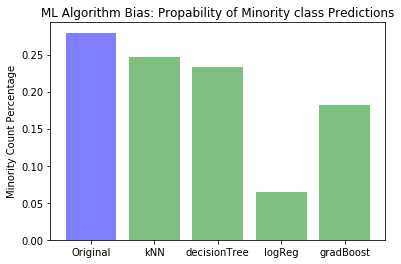

In [10]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

#Plot Minority Class Percentage 
def plotClassPercent(y_train, biasTestCount, label, normalise=True):
    # Add the original dataset minority count to the chart
    objects = ['Original'] + list(biasTestCount.keys())
    if normalise:
        minorityCounts = [Counter(y_train)[label]/len(y_train)] + list(biasTestCount.values())
    else:
        minorityCounts = [Counter(y_train)[label]] + list(biasTestCount.values())
    bars = np.arange(len(objects))

    plt.bar(bars, minorityCounts, align='center', color=['blue', 'green', 'green','green','green'], alpha=0.5)
    plt.xticks(bars, objects)
    plt.ylabel('Minority Count Percentage')
    plt.title('ML Algorithm Bias: Propability of Minority class Predictions')
 
    plt.show()
    
plotClassPercent(y_train, biasTestCount, 'L5')

From this chart we can suggest that k-NN is least affected by the majority class, and again showing how little logistic regression classified the minority class.

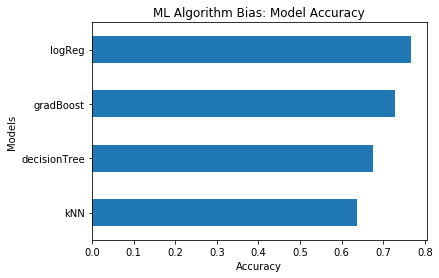

In [11]:
#Plot Accuracies
def plotAccuracies(accuracies):  
    acc_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
    acc_df = acc_df.sort_values(by=['Accuracy'])
    acc_df['Accuracy'].plot(kind='barh')
    plt.title('ML Algorithm Bias: Model Accuracy')
    plt.xlabel("Accuracy")
    plt.ylabel("Models")
    plt.show()


plotAccuracies(accuracies)

From this chart we can see that the classifier which classified more of the minority class has the worse accuracy. This could suggest that k-NN is wrongly identify the minority class, and the models are having difficulty splitting the 2 classes as there isn't enough data for the minority class.

In [12]:
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

#Function to plot confusion maxtrices, It has been modifed from the tutoiral notebooks.
#I have added input param ax, to allow for subplots.
def plot_confusion_matrix(y_true, y_pred, classes, ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

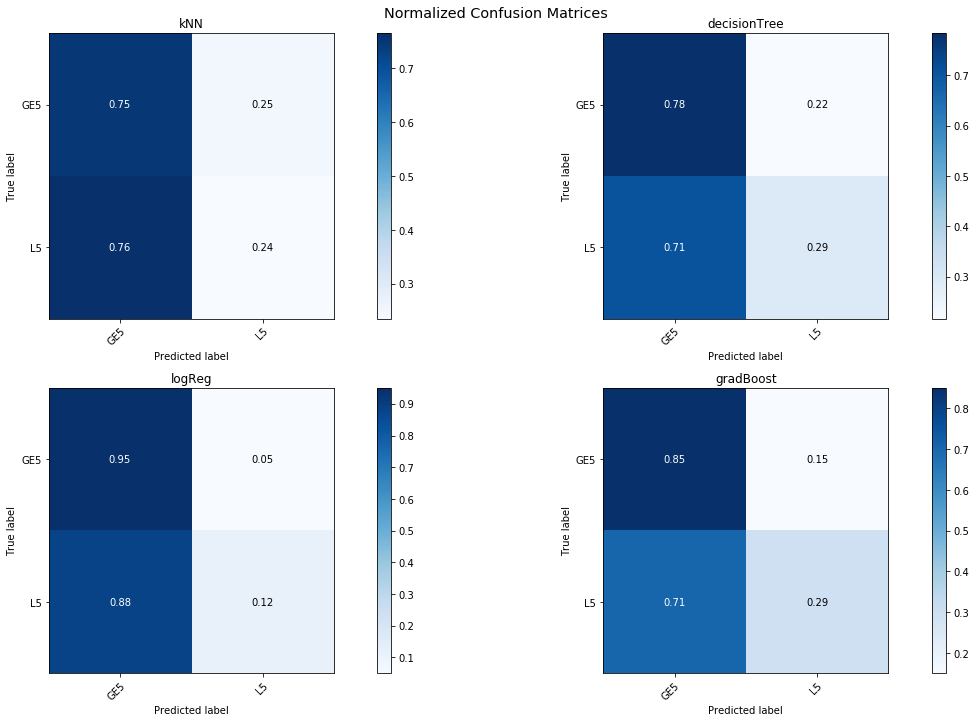

In [13]:
#Create a 2 by 2 confusion matrix to compare each model.
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]


for m in models: 
    plot_confusion_matrix(y_test, predictions[m], classes=['GE5', 'L5'], ax=figs[i], normalize=True, title=m)
    i += 1

fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

For confusion matrices, I'm gonna label GE5 has our 'false', and L5 as 'true'. Meaning that every L5 classified as a GE5 is a False Negative (lower left box). Using this we can see that all of our models perform well in classifying our majority set, with a range of 0.75 to 0.95 rate for True Negatives. However they all scored poorly in identifying our minority class with less than 30% of the minority class being classified correctly. We can see the bias for the majority class in the high rate (and dark colours) for our GE5 columns.

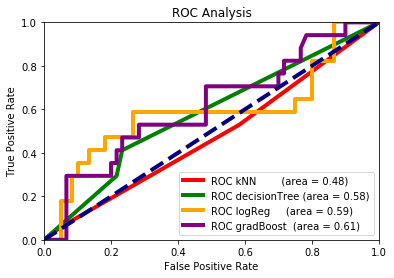

In [14]:
from sklearn.metrics import roc_curve, auc
#Plot ROC curves
def plotROC(y_test, rocProb, label):
    plt.figure()
    lw = 4

    l = [label]
    for m in models:
        fprX, tprX, t = roc_curve(y_test, rocProb[m][:,1], pos_label=l)
        roc_aucX = auc(fprX, tprX)
        label = 'ROC {:10} (area = {:.2f})'.format(m, roc_aucX)
        plt.plot(fprX, tprX, color=colour[m], lw=lw, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Analysis')
    plt.legend(loc="lower right")
    plt.show()
    
    
plotROC(y_test, rocProb, 'L5')

From the ROC we can see that in its raw state the classifiers are only slightly better than random classification. While logistic regression has the highest area, for some decision thresholds it performs lower than an random classifier. Which means that logistic regression is only better as a classifier for some thresholds, while gradient boosting is better across all thresholds.

### Cross Validation

From hold out testing we could see that how models have high false negative (FN) rating, as it will more likely predict our negative class (GE5) rather than our postive class (L5) Which shows they have a strong bias towards the majority class. We also want to see if this trends continues for cross validation.
sklearn cross_validate by default returns the accuracy of that fold/subset. Therefore to get the specific fp/tp rates we need to include a scoring method.

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#Define confusion matrix rates for scorer
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}


cross_biasTestCount = {}
cross_accuracies = {}

for m in models:
    cv_results = cross_validate(models[m], X, y, cv= 4,scoring=scoring, return_train_score=False, 
                                    verbose = 0, n_jobs = -1)
    
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_tn'].sum()+cv_results['test_fp'].sum())
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    
    p_total = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tp'].sum() + cv_results['test_tn'].sum())/len(y)
    
    cross_biasTestCount[m] = p_total
    cross_accuracies[m] = acc
    
    print("{:30} TN: {:.2f}   FP: {:.2f}\n{:30} FN: {:.2f}   TP: {:.2f}\n".format(type(models[m]).__name__, 
                                                                           tn_rate, fp_rate,'', fn_rate, tp_rate))
    

KNeighborsClassifier           TN: 0.66   FP: 0.34
                               FN: 0.54   TP: 0.46

DecisionTreeClassifier         TN: 0.68   FP: 0.32
                               FN: 0.59   TP: 0.41

LogisticRegression             TN: 0.96   FP: 0.04
                               FN: 0.81   TP: 0.19

GradientBoostingClassifier     TN: 0.55   FP: 0.45
                               FN: 0.52   TP: 0.48



From looking at the confusion matrix generated by cross validation we can see that most of the models were better at classifying the minority class than they were with hold-out testing. This suggest that by simply having more data we can reduce the affect of majority basis. It also could suggest that the random seed for splitting the datasets separated the two classes poorly.
Although the FP and TP rates are very similar which suggest that the models are classifying more of the minority class however they accuracy of doing so hasn't improved. Meaning that they are still having trouble correctly splitting the 2 classes and identifying the minority class due to the lack of data.

However logistic regression rates are nearly unchanged, which again shows that logistic regression is strongly affected by majority classes.

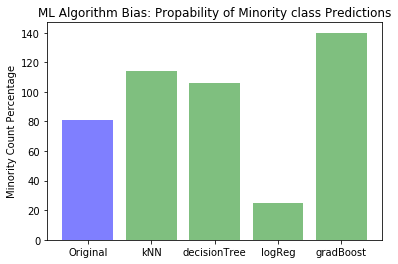

In [16]:
%matplotlib inline 
#Plot Minority Class Percentage 
plotClassPercent(y, cross_biasTestCount, 'L5', normalise=False)

This chart emphasis my point that the models are able to predict more of the minority class with using cross-validation, however they aren't improving the skill of separating the 2 classes as they predicted more of the minority than there actually was. Using cross-validation has shown improvement in the classification of the minority class and reducing majority bias as it has more of the data-set to work with, however I hope I will be able to improve the precision of the models later.

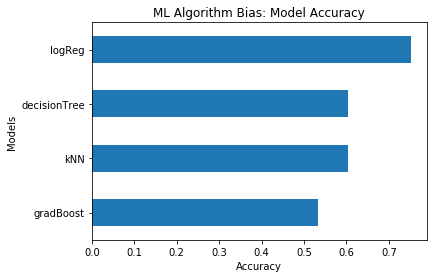

In [17]:
#Plot Accuracies
plotAccuracies(cross_accuracies)

By comparing this accuracy chart to the minority prediction count we can see that the models which are predicting more of the minority class have a lower accuracy, meaning that they are still having issues classifying the minority class.

## Strategies to Rectify Bias
There are 2 main types of techniques for handling imbalanced datasets, sampling and cost-sensitive. I will show an example from both to show the differences in methods. 

To evaluate the sampling strategies I will be using hold-out testing, as the models using this method performed worse, and I hope to see the sole improvement of the strategy. My computer will also thank me as cross-validation is very heaving in processing power and time.

### Sampling Strategy: SMOTE
The most common sampling methods are over-sampling and under-sampling, over-sampling will generate new data points for the minority class while under-sampling will remove data points from the majority class. These methods result in an balanced dataset. It is suggested that you should use under-sampling when you have a very large dataset, and over-sampling for a small dataset. Seeing as our dataset only has 306 entires I will use over-sampling.

A popular over-sampling technique is SMOTE (Synthetic minority oversampling technique). SMOTE generates new data point for the minority class by selecting points between the existing data points, it chooses the in-between points based on their local density and if amount of bordering with other class. Judging the bordering of the other classes measures the 'safeness' of data point. If a cluster of minority data points is surrounded by majority data points (on all sides) is less safe than a minority cluster with majority points on only one border/side of the cluster. 

In [18]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=24)

X_train_smote, y_train_smote = oversample.fit_sample(X_train, y_train)

print("Minority Count\tBefore:\t\t{:d}\n\t\tAfter SMOTE:\t{:d}".format(Counter(y_train)['L5'], 
                                                                              Counter(y_train_smote)['L5']))
print("Minority class\tBefore:\t\t{:.2}\n\t\tAfter SMOTE:\t{:.2f}".format((Counter(y_train)['L5']/len(y_train)), 
                                                                             (Counter(y_train_smote)['L5']/len(y_train_smote))))

Minority Count	Before:		64
		After SMOTE:	165
Minority class	Before:		0.28
		After SMOTE:	0.50


In [19]:
biasTestCount_smote = {}
accuracies_smote = {}
predictions_smote = {}
rocProb_smote = {}


print("Pred. L5 in test set : %.2f" % (Counter(y_test)['L5']/len(y_test)))
for m in models:
    model = models[m].fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    rocProb_smote[m] = y_score
    pred_count = Counter(y_pred)['L5']/len(y_pred)
    predictions_smote[m] = y_pred
    biasTestCount_smote[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    accuracies_smote[m] = acc 
    
    print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

Pred. L5 in test set : 0.22
KNeighborsClassifier           Pred. L5: 0.47 	 Accuracy: 0.52
DecisionTreeClassifier         Pred. L5: 0.34 	 Accuracy: 0.57
LogisticRegression             Pred. L5: 0.30 	 Accuracy: 0.71
GradientBoostingClassifier     Pred. L5: 0.30 	 Accuracy: 0.66


It seems that by up-sampling the minority class has decreased the overall accuracy of the models. This could suggest that the generation of new data points created by SMOTE increased the overlapping of classes and introduced additional noise into the dataset. This noise can make it hard for classifiers to correctly separate classes , thus resulting in the low accuracy rate shown.

By comparing minority percentage for the test set and the classifiers we can see that they predicted more minority than in the test set, and thus incorrectly identified minority classes.

However Logistic Regression again had a high accuracy and has the lowest minority split. However it is the closest to the test set, which means that Logistic Regression was un-affected by the possible noise generated by SMOTE, and was still able to classify somewhat accurately. Suggesting that Logistic Regression classifiers are best suited for datasets with a lot of noise.

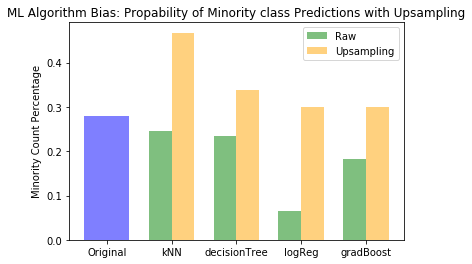

In [20]:
#Plot Minority Class Percentage Comparisons
def plotClassPercentCompare(y, biasTestCountOG, biasTestCountNEW, label, title, normalise=True):
    fig, ax = plt.subplots()
    width = 0.35
    # Add the original dataset minority count to the chart
    objects = ['Original'] + list(biasTestCountNEW.keys())
    if normalise:
        minorityCounts = [Counter(y)[label]/len(y)] + list(biasTestCountOG.values())
        minorityCountsNEW = [Counter(y)[label]/len(y)] + list(biasTestCountNEW.values())
    else:
        minorityCounts = [Counter(y)[label]] + list(biasTestCountOG.values())
        minorityCountsNEW = [Counter(y)[label]] + list(biasTestCountNEW.values())


    bars = np.arange(len(objects))

    p1 = ax.bar(bars, minorityCounts, width, align='center', 
                color=['blue', 'green', 'green','green','green'],alpha=0.5)

    p2 = ax.bar(bars+width, minorityCountsNEW, width, align='center', 
                color=['blue', 'orange', 'orange','orange','orange'],alpha=0.5)

    ax.legend((p1[1], p2[1]), ('Raw', title))

    bars = bars+(width/2)
    plt.xticks(bars, objects)
    plt.ylabel('Minority Count Percentage')
    title = 'ML Algorithm Bias: Propability of Minority class Predictions with ' + title
    plt.title(title)

    plt.show()
    
plotClassPercentCompare(y_train, biasTestCount, biasTestCount_smote, 'L5', 'Upsampling')

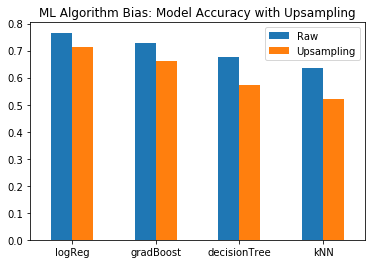

In [21]:
#Plot Accuracies Comparisons
def plotAccuraciesCompare(accuraciesOG, accuraciesNEW, title):
    index = list(accuraciesNEW.keys())
    
    acc_df = pd.DataFrame({
        'Raw': list(accuraciesOG.values()),
        title: list(accuraciesNEW.values())}, index=index)

    acc_df = acc_df.sort_values(by=['Raw'], ascending=False)
    title = 'ML Algorithm Bias: Model Accuracy with ' + title
    ax = acc_df.plot.bar(rot=0, title=title)
    
plotAccuraciesCompare(accuracies, accuracies_smote, 'Upsampling')

By comparing the 2 charts we can again see that with up-sampling we have improved the chance for classification of the minority class, however it has affected the accuracy of the models. 

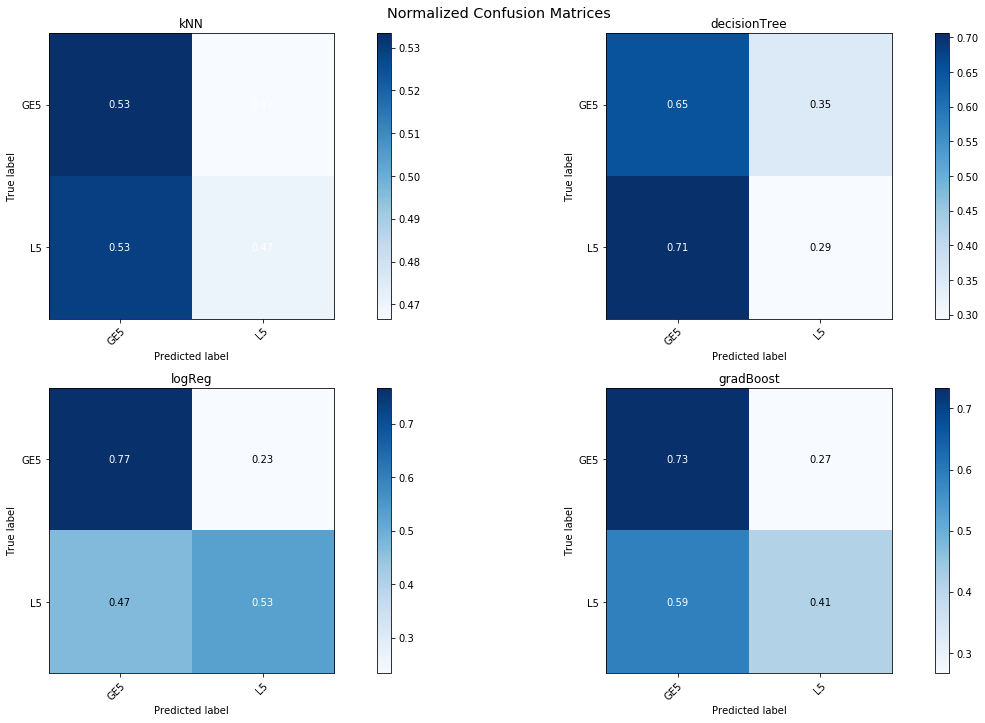

In [22]:
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

for m in models: 
    plot_confusion_matrix(y_test, predictions_smote[m], classes=['GE5', 'L5'], ax=figs[i], normalize=True,
                      title=m)
    i += 1


fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

The low accuracy can be shown in the confusion matrices. With k-NN values being all around the 0.5 mark, meaning that there was basically a coin flip to determine the 2 classes, thus resulting in a very low accuracy. This therefore shows that k-NN has greatly affected by the noise generated by SMOTE's up-sampling.

However with Logistic Regression and Gradient Boosting we can see a much higher TP rate, meaning that they have improved the classification of the minority class. Which can suggest that these 2 models are better suited for noise heavy data.

Gradient Boosting also out performed Decision Tree, suggesting that gradient boosting method has 'boosted' the decision tree's classification.

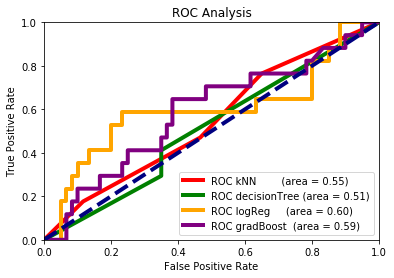

In [23]:
plotROC(y_test, rocProb_smote, 'L5')

Using SMOTE up-sampling seems to have very little affect on the ROC curve and area. It has actually made decision tree classifier worse overall with a area decreasing by 0.02. This again suggest that decision trees are having trouble classifying with the possible extra noise generated by SMOTE.

### Cost-Sensitive Strategy: Up-weighting and down-weighting

For cost-sensitive methods instead of generating/removing samples we increase/decrease the weight of the existing data points. These weights will then be used by the classifier model.

The most common cost-sensitive methods are up-weighting and down-weighting, much like over-sampling and under-sampling for up-weighting we increase the weight of the minority class. While down-weighting will decrease the weight of the majority class.I will use up-weighting by using sklearn's compute_sample_weight method. However sadly kNN.fit() does not support sample_weight, which means I will skip it for this fit example. This shows the limitations of weighting if kNN is best suited for your classification algorithm  

In [24]:
from sklearn.utils import class_weight
#Generate weights
class_weights = class_weight.compute_sample_weight('balanced', y_train)

print(class_weights[0:10])

[0.69393939 0.69393939 0.69393939 0.69393939 1.7890625  1.7890625
 0.69393939 0.69393939 0.69393939 0.69393939]


From using sample_weight we can see that it has given our minority class a weight of 1.7890625, with the majority having a reduce weight of 0.69393939. Using these weights the classification models should classify more of the minority class. 

In [25]:
biasTestCount_Weight = {}
accuracies_Weight = {}
predictions_Weight = {}

print("Pred. L5 in test set : %.2f" % (Counter(y_test)['L5']/len(y_test)))
for m in models:
    if m is 'kNN': continue
        
    y_pred = models[m].fit(X_train, y_train, sample_weight=class_weights).predict(X_test)
    pred_count = Counter(y_pred)['L5']/len(y_pred)
    predictions_Weight[m] = y_pred
    biasTestCount_Weight[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    accuracies_Weight[m] = acc 
    
    print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

Pred. L5 in test set : 0.22
DecisionTreeClassifier         Pred. L5: 0.31 	 Accuracy: 0.65
LogisticRegression             Pred. L5: 0.27 	 Accuracy: 0.71
GradientBoostingClassifier     Pred. L5: 0.29 	 Accuracy: 0.68


Again for with this strategy we have improved the classification of the minority class, but it has resulted reduction of accuracy. 

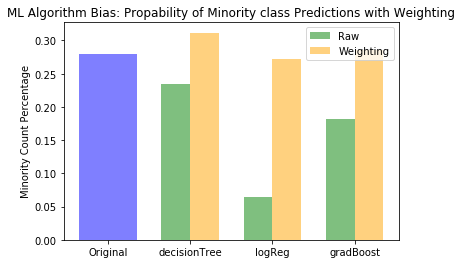

In [26]:
biasTestCount_withoutkNN = biasTestCount
biasTestCount_withoutkNN.pop('kNN', 'none')

#Plot Minority Class Percentage Comparisons
plotClassPercentCompare(y_train, biasTestCount_withoutkNN, biasTestCount_Weight, 'L5', 'Weighting')

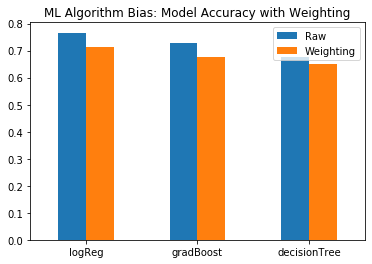

In [27]:
accuracies_withoutkNN = accuracies
accuracies_withoutkNN.pop('kNN', 'none')

#Plot Accuracies Comparisons
plotAccuraciesCompare(accuracies_withoutkNN, accuracies_Weight, 'Weighting')

Again by looking a the charts we have reduce the affect of majority bias, but it is with the cost of accuracy. However if you compare SMOTE and weighting accuracy charts we can see that weighting had an better accuracy, suggesting that is possibly a better strategy for rectifying minority bias. However it doesn't work for k-NN, which means that cost-sensitive methods are less flexible than sampling methods.

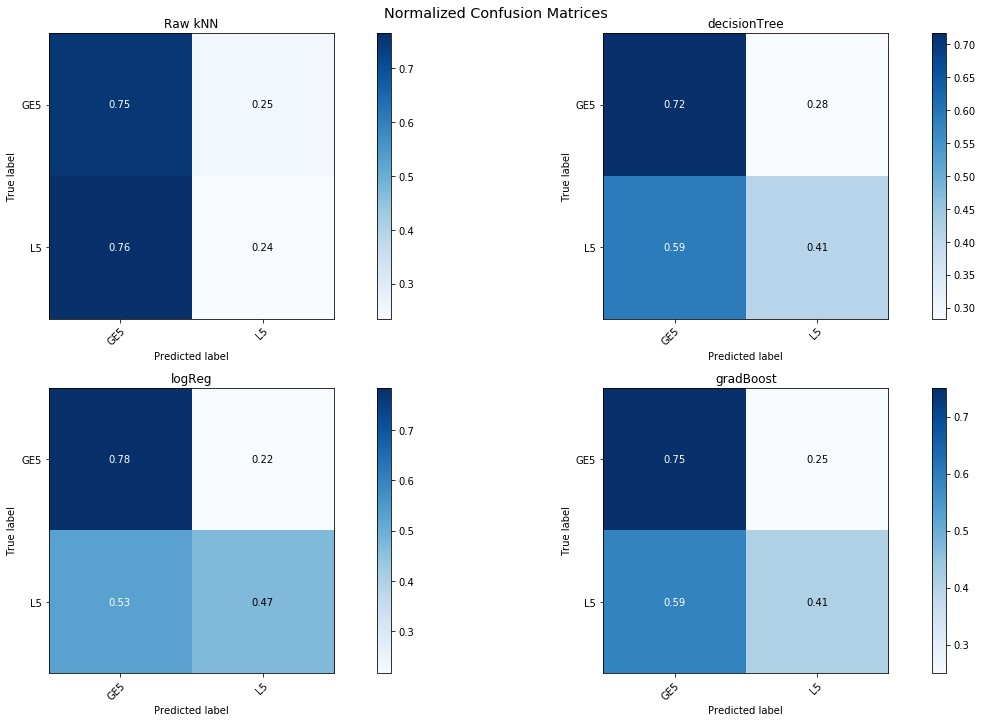

In [28]:
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

for m in models: 
    if m is 'kNN':
        plot_confusion_matrix(y_test, predictions[m], classes=['GE5', 'L5'], ax=figs[i], normalize=True,
                              title='Raw kNN')
    else:
        plot_confusion_matrix(y_test, predictions_Weight[m], classes=['GE5', 'L5'], ax=figs[i], normalize=True,
                              title=m)
    i += 1


fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

By looking that the confusion matrix we can again see that Cost-Sensitive weighting has improved the classification of minority class.

Seeing as we can't use weighing for kNN, I'll use down sampling for k-NN to see if that improves k-NN.
For down sampling we will randomly remove data points from the majority class, untill we get a balanced data-set.

In [29]:
from sklearn.utils import resample

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=24)

print("Majority Count\tBefore:\t{:d}\n\t\tAfter:\t{:d}".format(df_majority.shape[0], df_majority_downsampled.shape[0]))

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

y_downsampled = df_downsampled.pop('Survived').values
y_downsampled_class = df_downsampled.pop('Class').values
X_downsampled = df_downsampled.values
print("Minority class : %0.2f" % (Counter(y_downsampled)['L5']/len(y_downsampled)))

Majority Count	Before:	225
		After:	81
Minority class : 0.50


In [30]:
X_downsampled_train, X_downsampled_test, y_downsampled_train, y_downsampled_test = train_test_split(X_downsampled, 
                                                                                                    y_downsampled, 
                                                                                                    random_state=24)
y_pred = models['kNN'].fit(X_downsampled_train, y_downsampled_train).predict(X_downsampled_test)
pred_count = Counter(y_pred)['L5']/len(y_pred)
predictions_downsampled = y_pred
biasTestCount_downsampled = pred_count
acc = accuracy_score(y_downsampled_test, y_pred)
accuracies_downsampled = acc

print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models['kNN']).__name__, pred_count,acc))

KNeighborsClassifier           Pred. L5: 0.54 	 Accuracy: 0.66


The raw classifier had a L5 prediction of 0.25, and an accuracy of 0.64. By comparing these results we can see that again we have an improvement in the minority classification however it hasn't been at the cost of accuracy. This suggest that at least for k-NN classifier down-sampling is a better method for balancing a dataset.


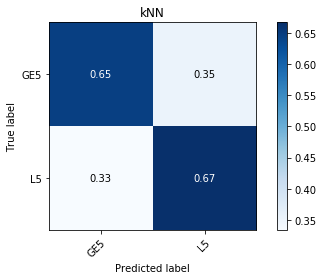

In [31]:
fig, ax= plt.subplots()

plot_confusion_matrix(y_downsampled_test, predictions_downsampled, classes=['GE5', 'L5'], ax=ax, normalize=True,
                              title='kNN')
plt.show()

From looking a the confusion matrix we can see a massive improvement in the TP result, and unlike the other methods it has reduce the rate of FN, which means that by down-sampling the majority we have made it much easier for k-NN for split each class.

## Test Strategy with Pima Indians Diabetes Dataset
To test the affectiveness of bias strategies I'm going to use this unbalanced diabetes detection dataset. 
This is a slightly larger dataset than our original dataset, I hope to see how each model and balancing strategy handle a larger dataset. A positive diabetes reading will be our minority dataset. It also has more variables which could affect the results of the models.

I will also be using both Hold-out and cross validation for my validation, and I will use both up and down sampling for each. I hope with this I will be able to see how each validation method can improve the classification, and whether the different sampling methods have different affects for each validation. With this I could possibly suggest the best combination of the 2 for rectifying majority bias.

In [32]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
diabetes = pd.read_csv(url, header=None)

#Assign Classes to binary
diabetes['Diabetes'] = 'Negative'
diabetes.loc[diabetes[8]==1,'Diabetes']='Positive'

#Split rows bassed on class
df_minority = diabetes[diabetes[8] == 1]
df_majority = diabetes[diabetes[8] == 0]

diabetes.head()

,0,1,2,3,4,5,6,7,8,Diabetes
0,6,148,72,35,0,33.6,0.627,50,1,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,0,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


In [33]:
diabetes.pop(8)
values = diabetes.values
X, y = values[:, :-1], values[:, -1]

print(diabetes['Diabetes'].value_counts())

Negative    500
Positive    268
Name: Diabetes, dtype: int64


### Hold-out testing

In [34]:
#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)
#Dictonaries to hold the minority count, the accuracie and the predictions for each model.
biasTestCount = {}
accuracies = {}
predictions = {}
rocProb = {}

print("Minority class : %0.2f" % (Counter(y_train)['Positive']/len(y_train)))

#Train and score each model
for m in models:
    model = models[m].fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    rocProb[m] = y_score
    
    pred_count = Counter(y_pred)['Positive']/len(y_pred)
    predictions[m] = y_pred
    biasTestCount[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    accuracies[m] = acc 
    
    print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

Minority class : 0.35
KNeighborsClassifier           Pred. L5: 0.31 	 Accuracy: 0.65
DecisionTreeClassifier         Pred. L5: 0.29 	 Accuracy: 0.69
LogisticRegression             Pred. L5: 0.19 	 Accuracy: 0.69
GradientBoostingClassifier     Pred. L5: 0.29 	 Accuracy: 0.73


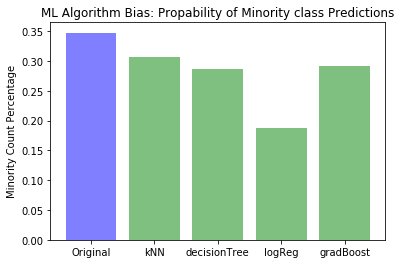

In [35]:
#Plot Minority Class Percentage
plotClassPercent(y_train, biasTestCount, 'Positive')

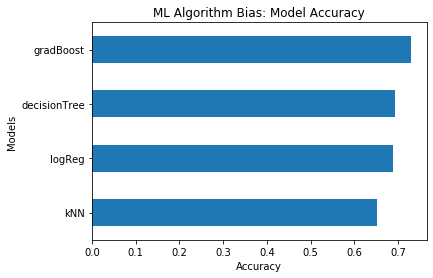

In [36]:
#Plot Accuracies
plotAccuracies(accuracies)

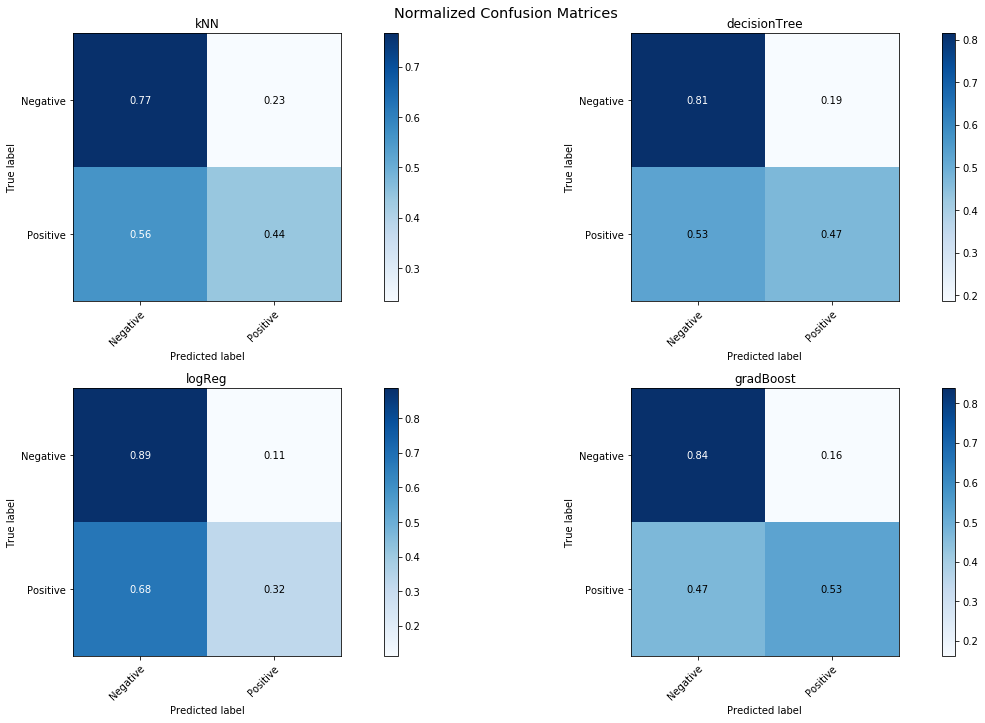

In [37]:
#Create a 2 by 2 confusion matrix to compare each model.
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]


for m in models: 
    plot_confusion_matrix(y_test, predictions[m], classes=['Negative', 'Positive'], ax=figs[i], normalize=True, title=m)
    i += 1

fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

By looking at the charts we can see that we are dealing with a very similar algorithm bias in our first dataset, we can see that we under classify the minority class. However for this dataset gradient boosting has a higher accuracy, which could suggest that gradient boosting is better at handling more variables.

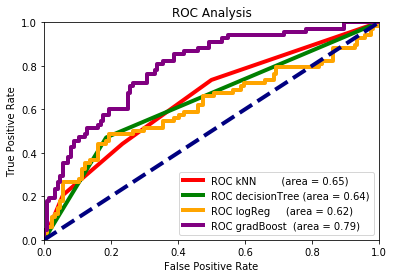

In [38]:
plotROC(y_test, rocProb, 'Positive')

From this ROC chart we can see that overall all our models are better than random a classifier. We again see that gradient boosting has a very good TP to FP rate with an ROC area of 0.79. Without any modification gradient boosting is less affected by minority bias in this dataset, this could be due to the more variables, or more data.

#### Strategies to Rectify Bias
To rectify the bias for this dataset I will be using 2 different sampling strategies as cost-sensitive weighting strategy couldn't handle k-NN. Interestingly Under-sampling was better for reducing bias in k-NN, I hope to see if the same happens for the rest of the models.  

##### Hold-out testing: Sampling Strategy: SMOTE

In [39]:
oversample = SMOTE(random_state=24)

X_train_smote, y_train_smote = oversample.fit_sample(X_train, y_train)

print("Minority Count\tBefore:\t\t{:d}\n\t\tAfter SMOTE:\t{:d}".format(Counter(y_train)['Positive'], 
                                                                              Counter(y_train_smote)['Positive']))
print("Minority class\tBefore:\t\t{:.2}\n\t\tAfter SMOTE:\t{:.2f}".format((Counter(y_train)['Positive']/len(y_train)), 
                                                                             (Counter(y_train_smote)['Positive']/len(y_train_smote))))

Minority Count	Before:		200
		After SMOTE:	376
Minority class	Before:		0.35
		After SMOTE:	0.50


In [40]:
biasTestCount_smote = {}
accuracies_smote = {}
predictions_smote = {}
rocProb_smote = {}

print("Pred. L5 in test set : %.2f" % (Counter(y_test)['Positive']/len(y_test)))
for m in models:
    model = models[m].fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    rocProb_smote[m] = y_score
    pred_count = Counter(y_pred)['Positive']/len(y_pred)
    predictions_smote[m] = y_pred
    biasTestCount_smote[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    accuracies_smote[m] = acc 
    
    print("{:30} Pred. L5: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

Pred. L5 in test set : 0.35
KNeighborsClassifier           Pred. L5: 0.44 	 Accuracy: 0.61
DecisionTreeClassifier         Pred. L5: 0.32 	 Accuracy: 0.70
LogisticRegression             Pred. L5: 0.38 	 Accuracy: 0.66
GradientBoostingClassifier     Pred. L5: 0.36 	 Accuracy: 0.70


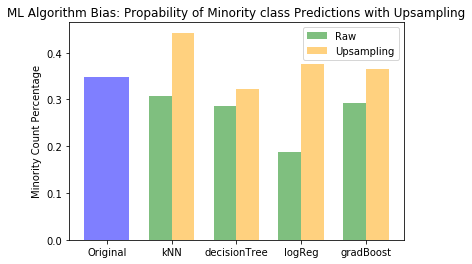

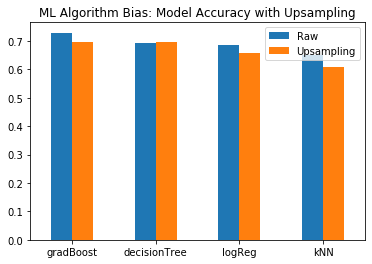

In [41]:
#Plot Minority Class Percentage Comparisons
plotClassPercentCompare(y_train, biasTestCount, biasTestCount_smote, 'Positive', 'Upsampling')

#Plot Accuracies Comparisons
plotAccuraciesCompare(accuracies, accuracies_smote, 'Upsampling')

From comparing the charts we can again see that we have improved the classification of the minority class. Also for decisions trees we have no change in the accuracy using SMOTE. This suggest that SMOTE is a good balancing method for classification with decisions trees.

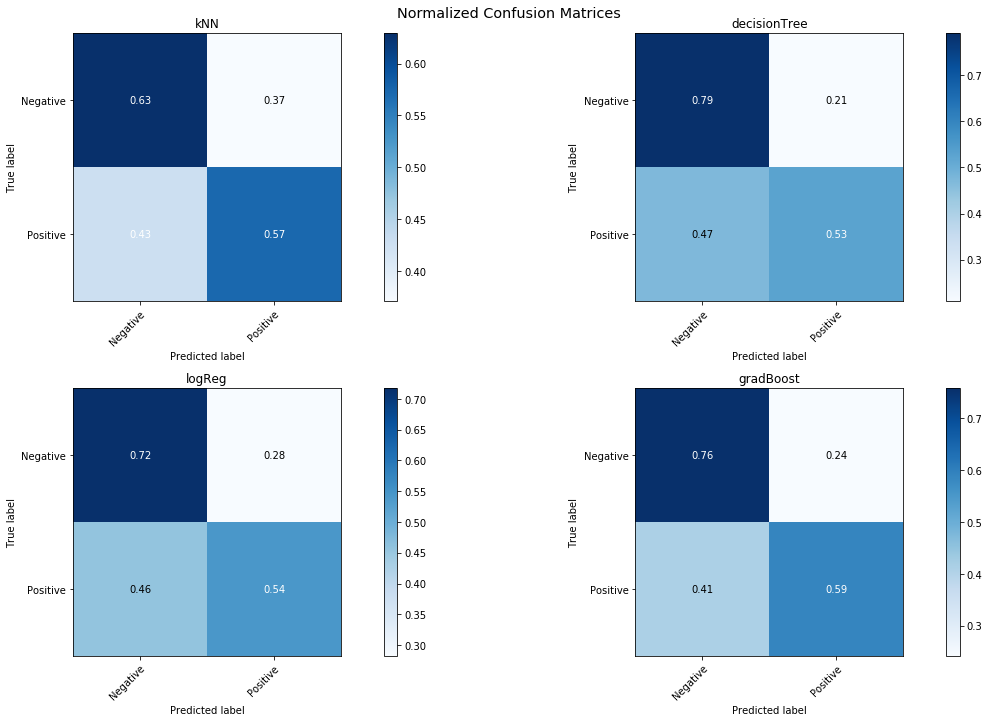

In [42]:
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

for m in models: 
    plot_confusion_matrix(y_test, predictions_smote[m], classes=['Negative', 'Positive'], ax=figs[i], normalize=True,
                      title=m)
    i += 1


fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

We can see that the loss of accuracy was due to the increasing of FP rating. Meaning that we have classified more of the positive class, however it has reduce the identification/separation of the 2 classes. This again suggest that the increased noise from SMOTE had made a more balanced dataset but at a cost for accuracy, as the data points classes are overlapping.

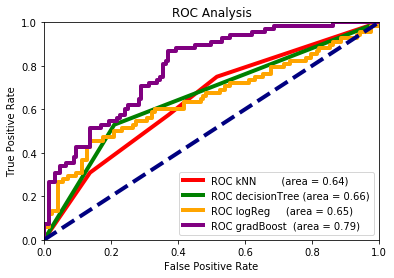

In [43]:
plotROC(y_test, rocProb_smote, 'Positive')

Using SMOTE has slightly improved decision tree and logistic regression, which suggest that the added minority samples has reduced the majority bias. However we can again see that k-NN has decreased, thus the extra noise generated by SMOTE has reduced the classification for k-NN.

#### Hold-out testing: Sampling Strategy: Down-sampling

In [44]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=24)

print("Majority Count\tBefore:\t{:d}\n\t\tAfter:\t{:d}".format(df_majority.shape[0], df_majority_downsampled.shape[0]))

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

y_downsampled = df_downsampled.pop('Diabetes').values
X_downsampled = df_downsampled.values
print("Minority class : %0.2f" % (Counter(y_downsampled)['Positive']/len(y_downsampled)))

Majority Count	Before:	500
		After:	268
Minority class : 0.50


In [45]:
X_downsampled_train, X_downsampled_test, y_downsampled_train, y_downsampled_test = train_test_split(X_downsampled, 
                                                                                                    y_downsampled, 
                                                                                                 random_state=24)
biasTestCount_downsampled = {}
accuracies_downsampled = {}
predictions_downsampled = {}
rocProb_downsampled = {}

for m in models:
    model = models[m].fit(X_downsampled_train, y_downsampled_train)
    y_pred = model.predict(X_downsampled_test)
    y_score = model.predict_proba(X_downsampled_test)
    pred_count = Counter(y_pred)['Positive']/len(y_pred)
    rocProb_downsampled[m] = y_score
    predictions_downsampled[m] = y_pred
    biasTestCount_downsampled[m] = pred_count
    acc = accuracy_score(y_downsampled_test, y_pred)
    accuracies_downsampled[m] = acc

    print("{:30} Pred. Positive: {:0.2f} \t Accuracy: {:.2f}".format(type(models[m]).__name__, pred_count,acc))

KNeighborsClassifier           Pred. Positive: 0.51 	 Accuracy: 0.71
DecisionTreeClassifier         Pred. Positive: 0.51 	 Accuracy: 1.00
LogisticRegression             Pred. Positive: 0.54 	 Accuracy: 0.97
GradientBoostingClassifier     Pred. Positive: 0.51 	 Accuracy: 1.00


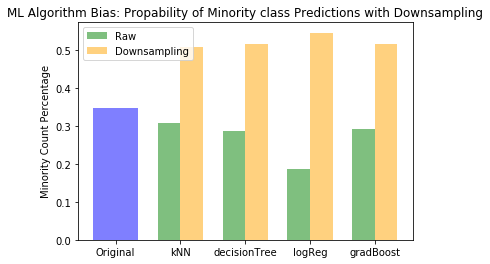

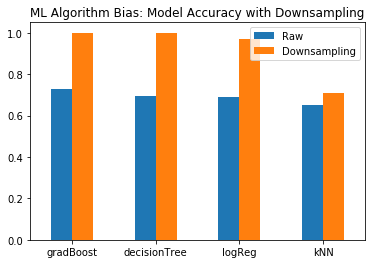

In [46]:
#Plot Minority Class Percentage
plotClassPercentCompare(y_train, biasTestCount, biasTestCount_downsampled, 'Positive', 'Downsampling')

#Plot Accuracies Comparisons
plotAccuraciesCompare(accuracies, accuracies_downsampled, 'Downsampling')

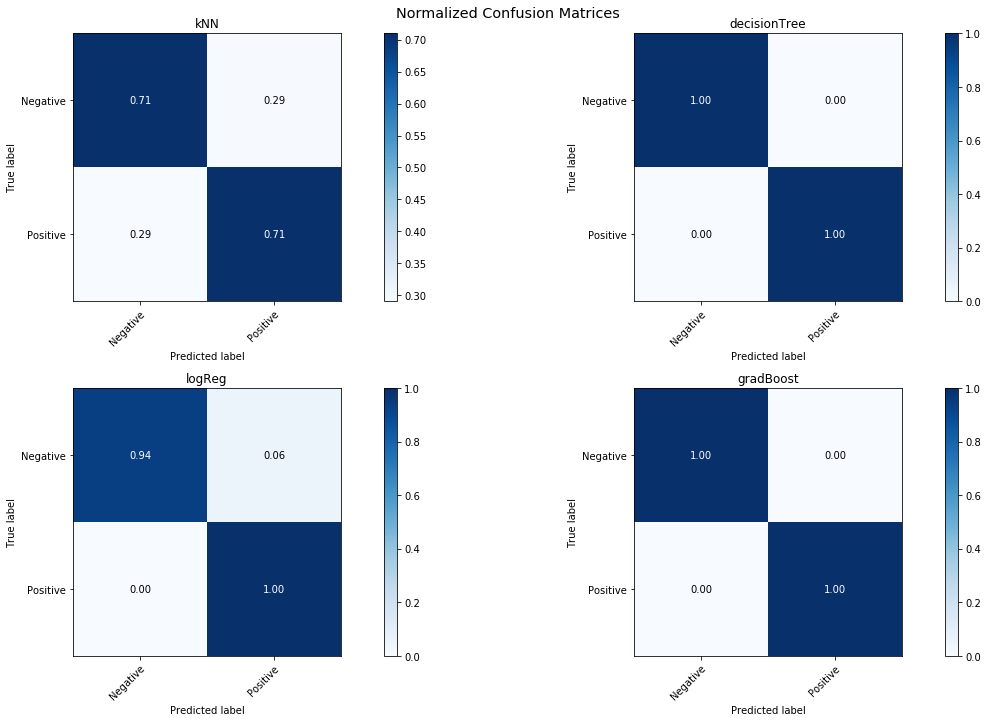

In [47]:
fig, axs= plt.subplots(2, 2, figsize=(20,10))
i = 0
figs = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

for m in models: 
    plot_confusion_matrix(y_downsampled_test, predictions_downsampled[m], classes=['Negative', 'Positive'], 
                          ax=figs[i], normalize=True, title=m)
    i += 1


fig.suptitle('Normalized Confusion Matrices', x=0.6, y=1, fontsize='x-large')
plt.show()

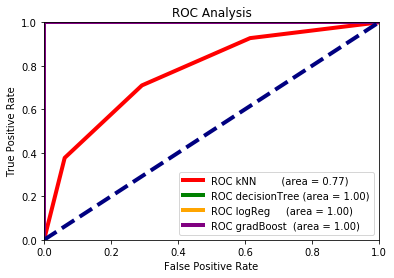

In [48]:
plotROC(y_downsampled_test, rocProb_downsampled, 'Positive')

From all of these charts we can see that down-sampling has greatly reduce the affect of majority bias. We can see that for all of the models we are classifying more of the minority class, and we have improved the accuracy. 

For Gradient Boosting and Decision Tree we have a perfect classification, which suggest that down-sampling is highly suited for balancing datasets for decision tree algorithms, and that the boosting possibly didn't boost the decision tree method as it was already prefect.

However perfect algorithms are very susceptible to over-fitting, which means that these models might perform poorly for unseen data. The over-fitting can be due to use reducing the datasize with down-sampling, meaning that we have less data for classification, and thus we are able to make an over fitted split between the two classes. This shows that with down-sampling we have removed a the majority bias, but at the cost of the overall performance of the classification.

From this validation test I can suggest a recommendation of down-sampling for rectify the minority bias in Pima Indians Diabetes Dataset, however further testing would need to be done with unseen-data to check if there has been over-fitting. Over-fitting can also be reduced by adjusting the classification models themselves. For example for decision trees by setting a minimum impurity decrease for splitting the dataset we can reduce over-fitting during classification.

### Cross Validation
I will also briefly test the balancing methods using cross validation to see if this validation method has an affect on the majority bias. For the sample methods I can use the whole dataset rather than the split sets, I hope that this will improve the overall quality of each model.

In [49]:
cross_biasTestCount = {}
cross_accuracies = {}

for m in models:
    cv_results = cross_validate(models[m], X, y, cv= 4,scoring=scoring, return_train_score=False, 
                                    verbose = 0, n_jobs = -1)
    
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_tn'].sum()+cv_results['test_fp'].sum())
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    
    p_total = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tp'].sum() + cv_results['test_tn'].sum())/len(y)
    
    cross_biasTestCount[m] = p_total
    cross_accuracies[m] = acc
    
    print("{:30} TN: {:.2f}   FP: {:.2f}\n{:30} FN: {:.2f}   TP: {:.2f}\n".format(type(models[m]).__name__, 
                                                                           tn_rate, fp_rate,'', fn_rate, tp_rate))
    

KNeighborsClassifier           TN: 0.79   FP: 0.21
                               FN: 0.45   TP: 0.55

DecisionTreeClassifier         TN: 0.76   FP: 0.24
                               FN: 0.40   TP: 0.60

LogisticRegression             TN: 0.87   FP: 0.13
                               FN: 0.62   TP: 0.38

GradientBoostingClassifier     TN: 0.86   FP: 0.14
                               FN: 0.40   TP: 0.60



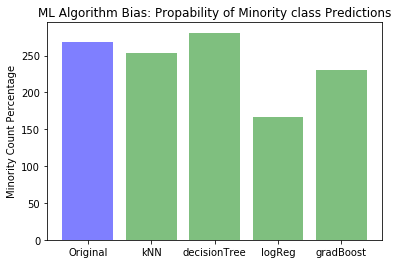

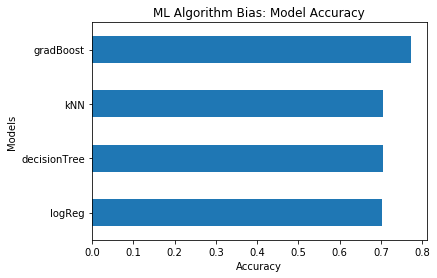

In [50]:
# Add the original dataset minority count to the chart
plotClassPercent(y, cross_biasTestCount, 'Positive', normalise=False)
#Plot Accuracies
plotAccuracies(cross_accuracies)

If we compare the raw Hold-out testing and cross validation charts we can see that there has been an improvement in both reducing the majority bias and increasing accuracy when using cross validation.

#### Cross Validation: Sampling Strategy: SMOTE

In [51]:
oversample = SMOTE(random_state=24)

X_smote, y_smote = oversample.fit_sample(X, y)

print("Minority Count\tBefore:\t\t{:d}\n\t\tAfter SMOTE:\t{:d}".format(Counter(y)['Positive'], 
                                                                              Counter(y_smote)['Positive']))
print("Minority class\tBefore:\t\t{:.2}\n\t\tAfter SMOTE:\t{:.2f}".format((Counter(y)['Positive']/len(y)), 
                                                                             (Counter(y_smote)['Positive']/len(y_smote))))

Minority Count	Before:		268
		After SMOTE:	500
Minority class	Before:		0.35
		After SMOTE:	0.50


In [52]:
cross_biasTestCount_smote = {}
cross_accuracies_smote = {}

for m in models:
    cv_results = cross_validate(models[m], X_smote, y_smote, cv= 4,scoring=scoring, return_train_score=False, 
                                    verbose = 0, n_jobs = -1)
    
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_tn'].sum()+cv_results['test_fp'].sum())
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    
    p_total = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tp'].sum() + cv_results['test_tn'].sum())/len(y)
    
    cross_biasTestCount_smote[m] = p_total
    cross_accuracies_smote[m] = acc
    
    print("{:30} TN: {:.2f}   FP: {:.2f}\n{:30} FN: {:.2f}   TP: {:.2f}\n".format(type(models[m]).__name__, 
                                                                           tn_rate, fp_rate,'', fn_rate, tp_rate))
    

KNeighborsClassifier           TN: 0.64   FP: 0.36
                               FN: 0.15   TP: 0.85

DecisionTreeClassifier         TN: 0.74   FP: 0.26
                               FN: 0.21   TP: 0.79

LogisticRegression             TN: 0.66   FP: 0.34
                               FN: 0.26   TP: 0.74

GradientBoostingClassifier     TN: 0.78   FP: 0.22
                               FN: 0.19   TP: 0.81



There has been a massive improvement in the TP rate for using SMOTE and using cross validation.

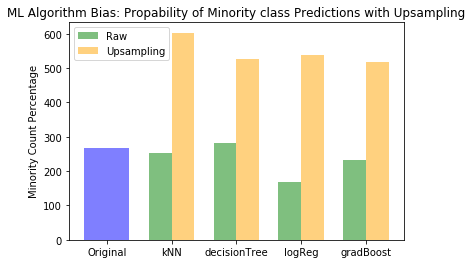

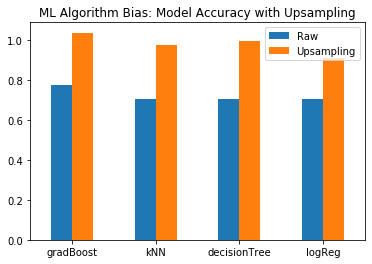

In [53]:
#Plot Minority Class Percentage Comparisons
plotClassPercentCompare(y, cross_biasTestCount, cross_biasTestCount_smote, 'Positive', 'Upsampling', normalise=False)
#Plot Accuracies Comparisons
plotAccuraciesCompare(cross_accuracies, cross_accuracies_smote, 'Upsampling')

From these charts we can see that with SMOTE we are classifying more of the minority class, and we have increased the overall accuracy for each model. Which suggest that due to cross validation's increase in dataset size SMOTE is able to more accurately generate the minority data-points.

#### Cross Validation: Sampling Strategy: Down-sampling

In [54]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=24)

print("Majority Count\tBefore:\t{:d}\n\t\tAfter:\t{:d}".format(df_majority.shape[0], df_majority_downsampled.shape[0]))

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

y_downsampled = df_downsampled.pop('Diabetes').values
X_downsampled = df_downsampled.values
print("Minority class : %0.2f" % (Counter(y_downsampled)['Positive']/len(y_downsampled)))

Majority Count	Before:	500
		After:	268
Minority class : 0.50


In [55]:
cross_biasTestCount_downsampled = {}
cross_accuracies_downsampled = {}

for m in models:
    cv_results = cross_validate(models[m], X_downsampled, y_downsampled, cv= 4,scoring=scoring, return_train_score=False, 
                                    verbose = 0, n_jobs = -1)
    
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_tn'].sum()+cv_results['test_fp'].sum())
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    
    p_total = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tp'].sum() + cv_results['test_tn'].sum())/len(y_downsampled)
    
    cross_biasTestCount_downsampled[m] = p_total
    cross_accuracies_downsampled[m] = acc
    
    print("{:30} TN: {:.2f}   FP: {:.2f}\n{:30} FN: {:.2f}   TP: {:.2f}\n".format(type(models[m]).__name__, 
                                                                           tn_rate, fp_rate,'', fn_rate, tp_rate))
    

KNeighborsClassifier           TN: 0.72   FP: 0.28
                               FN: 0.28   TP: 0.72

DecisionTreeClassifier         TN: 1.00   FP: 0.00
                               FN: 0.00   TP: 1.00

LogisticRegression             TN: 0.96   FP: 0.04
                               FN: 0.00   TP: 1.00

GradientBoostingClassifier     TN: 1.00   FP: 0.00
                               FN: 0.00   TP: 1.00



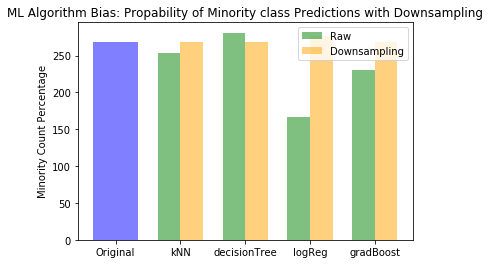

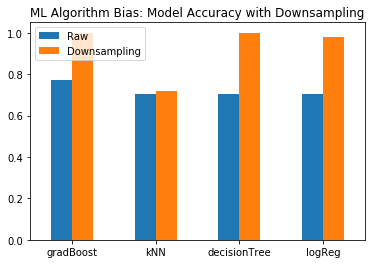

In [56]:
#Plot Minority Class Percentage
plotClassPercentCompare(y_downsampled, cross_biasTestCount, cross_biasTestCount_downsampled, 'Positive', 'Downsampling',
                        normalise=False)

#Plot Accuracies Comparisons
plotAccuraciesCompare(cross_accuracies, cross_accuracies_downsampled, 'Downsampling')

Using down-sampling has had a very similar affect on the accuracy and the prediction of minority class for both validation strategies. From these comparisons I overall rate the performance of cross-validating higher than hold-out testing. However cross-validating has a much higher processing time. 

The down-sampling method achieved a near perfect classification, however those predictions are most likely over fitted. This over-fitting is most likely due to the reduction of the dataset due to the down-sampling. Due to the over-fitting it could possibly be better to instead use cross-validation and SMOTE up sampling, as for the Gradient Boosting Classifier achieved a high accuracy and high TP and TN rates, which means its good for classify both majority and minority classes in our dataset without over-fitting the data.  

Therefore to summarise, for dealing with unbalanced datasets using a combination of cross validation and SMOTE up sampling and Gradient Boosting Classifier, may result in a good accuracy test for both the minority and majority classification. However using down sampling instead results in a perfect classifier for Decision Trees which could however be over-fitted. To further decide of the correct classifier for these dataset we will need to test both methods with unseen data and evaluate their performance.